<a href="https://colab.research.google.com/github/MonikSense/Diabetes/blob/main/ganeshshap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Selected numerical features: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

Final Model Performance:

                     Accuracy  Precision  Recall     F1  ROC-AUC
Logistic Regression     0.960      0.862   0.628  0.727    0.960
Random Forest           0.971      0.993   0.668  0.799    0.973
KNN                     0.960      0.869   0.621  0.725    0.901
SVM                     0.961      0.913   0.596  0.721    0.958
Decision Tree           0.971      0.972   0.675  0.796    0.974
Naïve Bayes             0.632      0.184   0.972  0.310    0.914


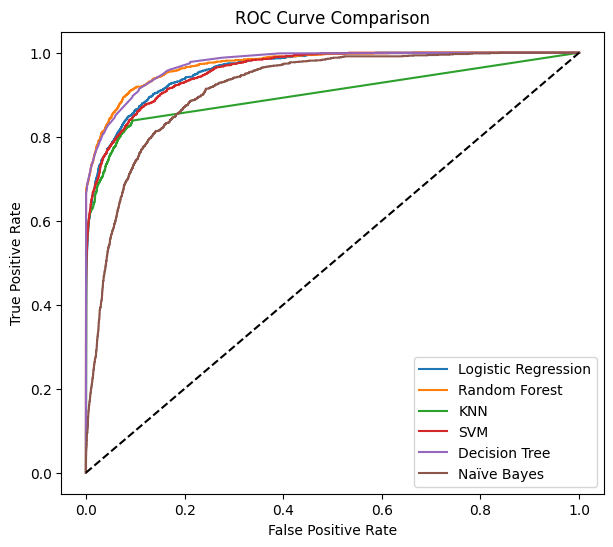

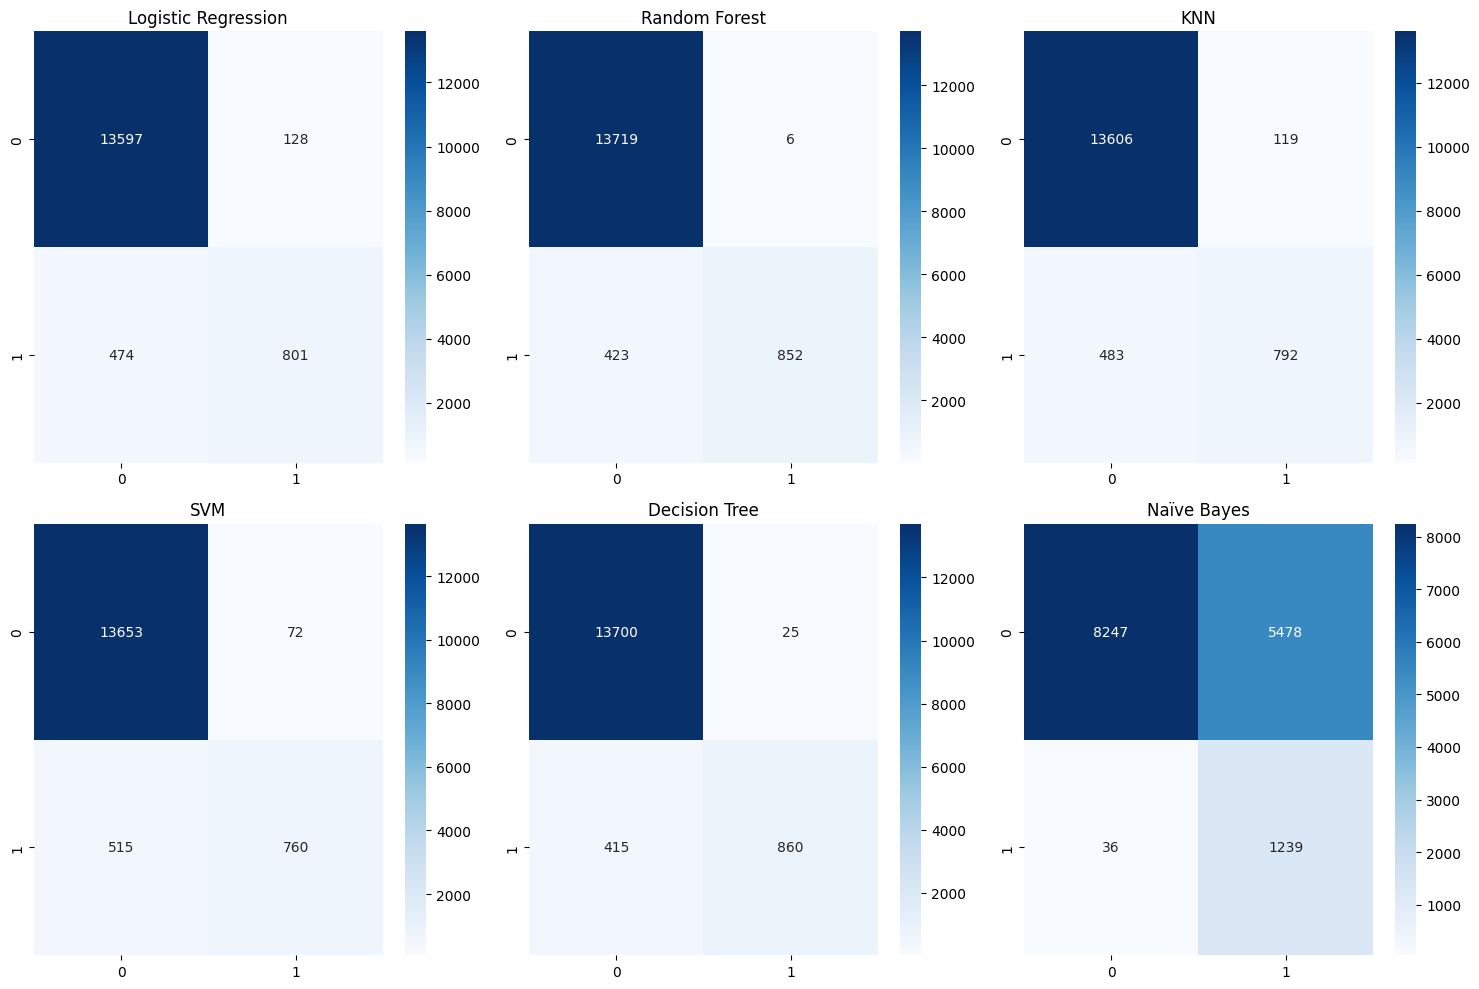

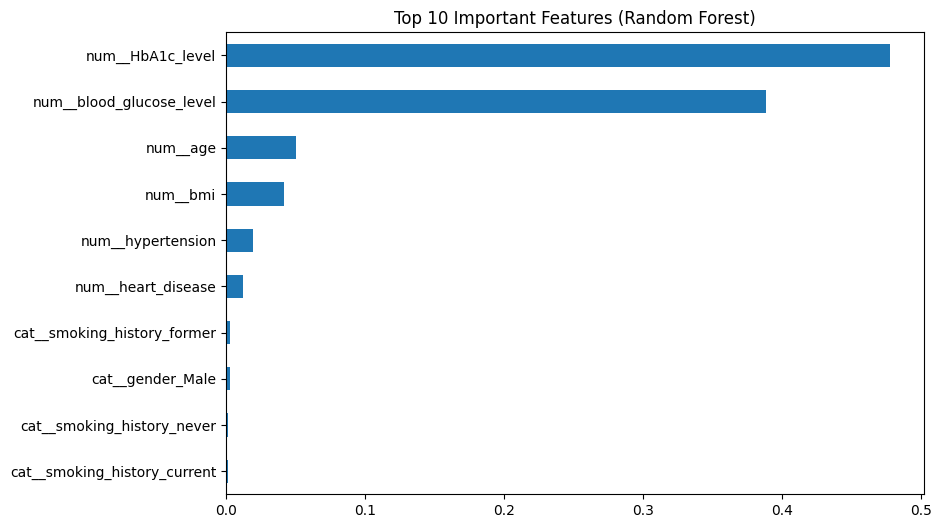

 99%|===================| 993/1000 [00:22<00:00]       

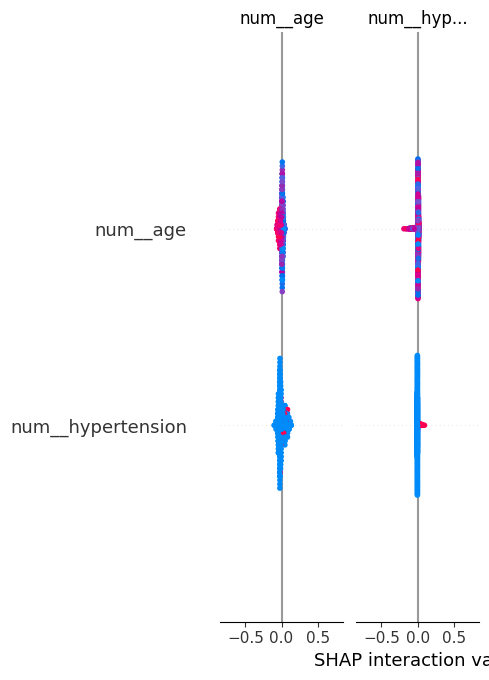

 96%|=================== | 959/1000 [00:21<00:00]       

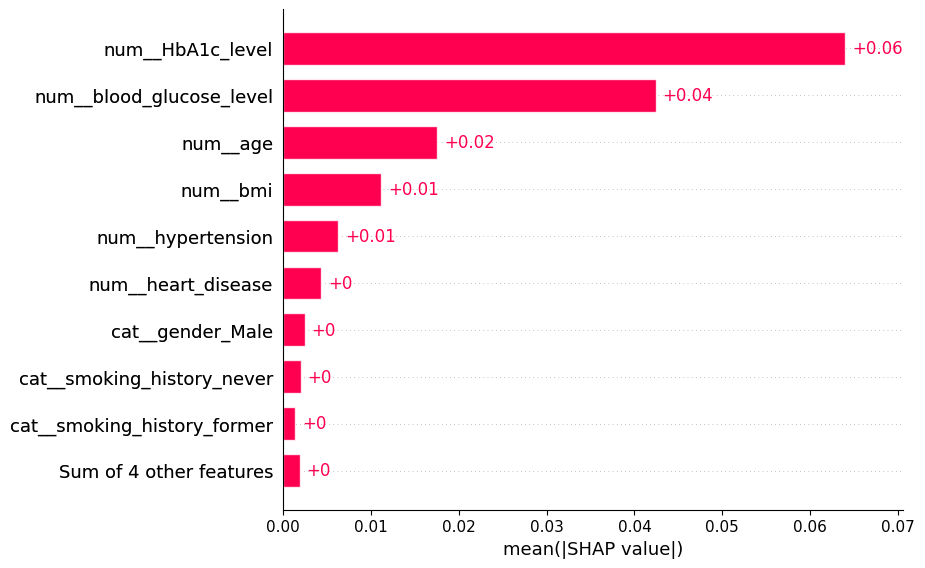

In [4]:
# ============================================================
# Diabetes Early Detection using EHR + Optimized ML Models
# SHAP FIXED VERSION (NO SHAPE ERRORS)
# ============================================================

# 1️⃣ Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import shap
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 2️⃣ Load Dataset
# ============================================================
df = pd.read_csv(
    "https://raw.githubusercontent.com/MonikSense/Diabetes/refs/heads/main/diabetes_prediction_dataset.csv"
)

X = df.drop("diabetes", axis=1)
y = df["diabetes"]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# ============================================================
# 3️⃣ Correlation-based Feature Selection (Numerical)
# ============================================================
corr = df[num_cols + ["diabetes"]].corr()
target_corr = corr["diabetes"].abs()

selected_num_cols = target_corr[target_corr >= 0.15].index.tolist()
selected_num_cols.remove("diabetes")

selected_features = selected_num_cols + cat_cols

print("Selected numerical features:", selected_num_cols)

# ============================================================
# 4️⃣ Train / Validation / Test Split
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X[selected_features], y,
    test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

rf_pipe = trained_models["Random Forest"]
X_test_trans = rf_pipe.named_steps["preprocessor"].transform(X_test)
feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()

# ============================================================
# 5️⃣ Preprocessing
# ============================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), selected_num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# ============================================================
# 6️⃣ Models
# ============================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(
        n_estimators=150, max_depth=12, n_jobs=-1, random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "SVM": SVC(kernel="linear", probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Naïve Bayes": GaussianNB()
}

trained_models = {}
performance = {}

# ============================================================
# 7️⃣ Train Once & Evaluate
# ============================================================
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    performance[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

results_df = pd.DataFrame(performance).T.round(3)
print("\nFinal Model Performance:\n")
print(results_df)

# ============================================================
# 8️⃣ ROC Curves
# ============================================================
plt.figure(figsize=(7,6))
for name, pipe in trained_models.items():
    y_prob = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ============================================================
# 9️⃣ Confusion Matrices
# ============================================================
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.ravel()

for ax, (name, pipe) in zip(axes, trained_models.items()):
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()

# ============================================================
# 🔟 Feature Importance (Random Forest)
# ============================================================
rf_pipe = trained_models["Random Forest"]

# ✅ CORRECT way to extract feature names
feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()

importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(9,6))
feat_imp[:10].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

# ============================================================
# 1️⃣1️⃣ SHAP – FIXED & STABLE
# ============================================================
X_test_trans = rf_pipe.named_steps["preprocessor"].transform(X_test)

# ✅ Use SHAP Explainer (AUTO-HANDLES SHAPES)
explainer = shap.Explainer(
    rf_pipe.named_steps["model"],
    X_test_trans,
    feature_names=feature_names
)

shap_values = explainer(X_test_trans[:500])  # sample for speed

shap.summary_plot(shap_values, X_test_trans[:500])
# ============================================================
# SHAP BAR PLOT (GLOBAL IMPORTANCE – CLASS 1)
# ============================================================

import shap

# Build explainer
explainer = shap.Explainer(
    rf_pipe.named_steps["model"],
    X_test_trans,
    feature_names=feature_names
)

# Compute SHAP values (sampled for speed)
shap_values = explainer(X_test_trans[:500])

# ✅ SELECT CLASS 1 (Diabetic)
shap_values_class1 = shap_values[:, :, 1]

# BAR PLOT (NOW SAFE)
shap.plots.bar(
    shap_values_class1,
    max_display=10
)


# ============================================================
# ✅ END
# ============================================================
